## Lab 1 - A-star

Implement the A* to the set cover problem

In [1]:
import numpy as np
from random import random
from functools import reduce
import queue
import matplotlib.pyplot as plt
from collections import namedtuple
import math
from tqdm import tqdm

### Set cover definition

Given a set $\mathcal{U}$ (universe) of $u$ elements, and a collection $\mathcal{S}$ of $s$ subsets whose union equals the universe, we want to find a collection $\mathcal{C}\subseteq\mathcal{S}$ of size $c \leq s$ such that the union of all elements in $\mathcal{C}$ is equal to $\mathcal{U}$.
Our objective is to minimize $c$.

In the code, $u$ is referred as `PROBLEM_SIZE`, $s$ is referred as `NUM_SETS`.  
Moreover, we added a parameter $p$ (`P` in the code below) that indicates the probability of a given element being present in any of the elements of $\mathcal{S}$.

In [2]:
PROBLEM_SIZE = 25
NUM_SETS = 64
State = namedtuple('state', ['taken', 'not_taken'])
P = 0.5
SETS = tuple(np.array([random() < P for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))

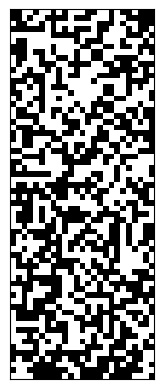

In [3]:
def draw_sol(map): #visualize a subset of S as a grid of pixels. Each row is a set, black pixels are the elements taken in that set.
    plt.imshow(map, cmap="binary")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show();

draw_sol(np.vstack([SETS[i] for i in range(NUM_SETS)]))

In [4]:
def draw_plots(size, plots, xlabel="x", ylabel="y", legend_title=" "): # draw some plots and show them in a graph
    for label in plots.keys():
        plt.plot(len(plots[label]), plots[label], label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, size))
    plt.legend(title=legend_title)
    plt.show()

In [5]:
def goal_check(state): # function to check if we found a set cover
    return len(state.taken) > 0 and np.all(reduce(np.logical_or, [SETS[i] for i in state.taken])) 

assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable" # check if the problem is solvable

The code below is an implementation of best-first search.
`f` denotes the evaluation function used to calculate the priority. (Nodes with smaller values of f are expanded first)  

In [6]:
def find_solution(f = lambda s: len(s.taken), verbose=True, ubound=10000): #f is the function that calculates the cost of reaching a state
    frontier = queue.PriorityQueue()
    frontier.put((0, State(set(), set(range(NUM_SETS)))))  #initial state
    _, curr_state = frontier.get()
    counter = 0
    while not goal_check(curr_state):
        counter += 1
        if ubound and ubound < counter:
            del frontier
            print("Computation timed out")
            return -1, counter
        for action in curr_state.not_taken:
            new_state = State(curr_state.taken ^ {action}, curr_state.not_taken ^ {action}) #using XOR for both operations
            frontier.put((f(new_state), new_state))
        _, curr_state = frontier.get()
    if verbose:
        print("Found solution", curr_state.taken ,"in", counter, "steps.\nCost:", len(curr_state.taken))
        draw_sol(np.vstack([SETS[i] for i in curr_state.taken]))
    del frontier
    return len(curr_state.taken), counter

Let's calculate solutions with breadth-first and greedy best-first algorithms to use them as a benchmark:

## Breadth First


The evaluation function is defined as:
$$f(n) = g(n)$$
$g(n)$ is the number of edges traversed to reach the node $n$.

Found solution {31, 63} in 76 steps.
Cost: 2


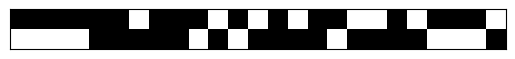

In [7]:
bf_cost, bf_steps = find_solution()

## Greedy Best First

The evaluation function is defined as 
$$f(n) = h(n) $$ 
$h_1(n)$ is defined as the number of elements of $\mathcal{U}$ that are missing from $\mathcal{C}_n$, where $\mathcal{C}_n$ is the collection of sets taken at node $n$.

In [8]:
def covered(state):
    return reduce(np.logical_or, [SETS[i] for i in state.taken], [False for _ in range(PROBLEM_SIZE)])

In [9]:
def heur1(state):
    return np.sum(np.logical_not(covered(state)))

Found solution {62, 30} in 2 steps.
Cost: 2


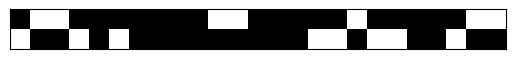

In [10]:
gbf_cost, gbf_steps = find_solution(heur1)

# A*

The evaluation function is defined as

$$f(n) = g(n) + h(n)$$

- $g(n)$ is the cost of traversing an edge
- $h(n)$ is a heuristic distance value

## First approach

Let's try using $h_1(n)$ as a heuristic for the A* algorithm.

Found solution {62, 30} in 2 steps.
Cost: 2


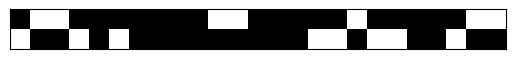

In [11]:
a1_cost, a1_steps = find_solution(lambda s: heur1(s) + len(s.taken))

### Observations:
The first approach doesn't provide any improvement when compared to greedy best first. In particular, it doesn't always find an optimal solution. This may suggest us that the heuristic $h_1$ is not admissible.

## Changing heuristics
Let's try another $h(n)$.  
$h_1(n)$ assumed that, given a node $n$ and being $\mathcal{C}_n$ the collection of sets taken at node $n$, we need to traverse at least $m = u - \#\mathcal{C}_n$ nodes to find a solution starting from $n$.  
This is generally false.  
  
The expected number of elements of $\mathcal{U}$ in a random element $\mathcal{X}$ of $\mathcal{S}$ is:
$$E[{\mathcal{\#X}}] = p\#\mathcal{U}$$  
Where $p$ is the (uniform) probability of a given element being present in any of the subsets of $\mathcal{S}$.  
We can change the heuristic by defining
$$h_2(n) = \frac{h_1(n)}{E[{\mathcal{\#X}}]}$$

In [12]:
def heur2(state):
    return math.ceil(heur1(state)/(P * PROBLEM_SIZE))

Found solution {60, 30} in 5 steps.
Cost: 2


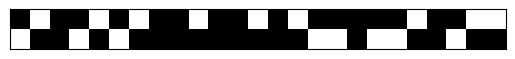

In [13]:
gbf2_cost, gbf2_steps = find_solution(heur2)

Found solution {60, 30} in 10 steps.
Cost: 2


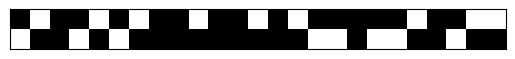

In [14]:
a2_cost, a2_steps = find_solution(lambda s: len(s.taken) + heur2(s))

This heuristic is still not optimistic, because there may be some elements of $\mathcal{S}$ bigger than $E[\mathcal{\#X}]$.  
Let's try another heuristic.  
Instead of using an expected value for the division, we calculate the size of the largest element of $\mathcal{S}$.

In [15]:
def heur3(state):
    largest_set_size = max(sum(s) for s in SETS)
    return math.ceil(heur1(state)/largest_set_size)

Found solution {60, 30} in 6 steps.
Cost: 2


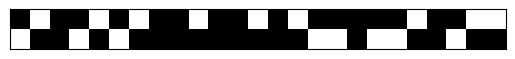

In [16]:
gbf3_cost, gbf3_steps = find_solution(heur3)

Found solution {63, 31} in 16 steps.
Cost: 2


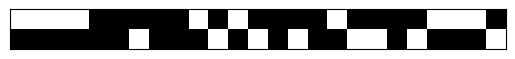

In [17]:
a3_cost, a3_steps = find_solution(lambda s: len(s.taken) + heur3(s))

Let's try a couple more heuristics.  
Instead of checking the largest element of $\mathcal{S}$, we look for the one with the most element missing from our state.

In [18]:
def heur4(state):
    current_cover = covered(state)
    if np.all(current_cover):
        return 0
    missing = [np.logical_and(np.logical_not(current_cover), s) for s in SETS]
    largest_missing = max(sum(missing))
    return math.ceil(sum(np.logical_not(current_cover)) / largest_missing)

Found solution {60, 30} in 6 steps.
Cost: 2


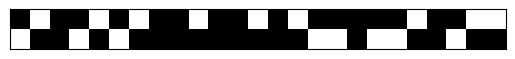

Found solution {63, 31} in 16 steps.
Cost: 2


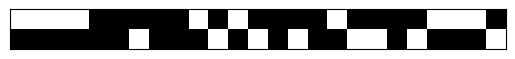

In [19]:
gbf4_cost, gbf4_steps = find_solution(heur4)
a4_cost, a4_steps = find_solution(lambda s: len(s.taken) + heur4(s))

Instead of considering the same element of $\mathcal{S}$ multiple times, we count the minimum number of _distinct_ element of $\mathcal{S}$ that we need for the solution,

In [20]:
def heur5(state):
    current_cover = covered(state)
    if np.all(current_cover):
        return 0
    missing_size = sum(np.logical_not(current_cover))
    missing = [np.logical_and(np.logical_not(current_cover), s) for s in SETS]
    missing = sorted(missing, key=sum, reverse=True)
    taken = 1
    while sum(sum(missing[:taken])) < missing_size:
        taken += 1
    return taken

Found solution {60, 30} in 2 steps.
Cost: 2


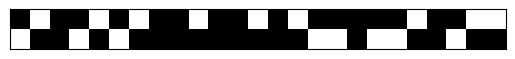

Found solution {60, 30} in 4 steps.
Cost: 2


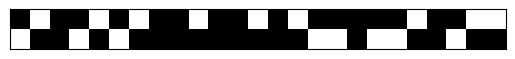

In [21]:
gbf5_cost, gbf5_steps = find_solution(heur5)
a5_cost, a5_steps = find_solution(lambda s: len(s.taken) + heur5(s))

Whenever we decide to consider an element, we recalculate the missing element from what would be the new solution.

In [22]:
def heur6(state):
    def missing(cover):
        missing = [np.logical_and(np.logical_not(cover), s) for s in SETS]
        return max(missing, key=sum)
    cover = covered(state)
    if np.all(cover):
        return 0
    taken = 1
    while not np.all(cover):
        taken += 1
        cover = np.logical_or(cover, missing(cover))
    return taken

Found solution

 {60, 30} in 2 steps.
Cost: 2


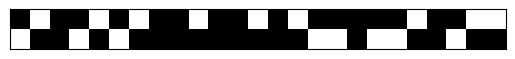

Found solution {60, 30} in 2 steps.
Cost: 2


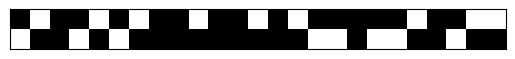

In [23]:
gbf6_cost, gbf6_steps = find_solution(heur6)
a6_cost, a6_steps = find_solution(lambda s: len(s.taken) + heur6(s))

Let's compare the results

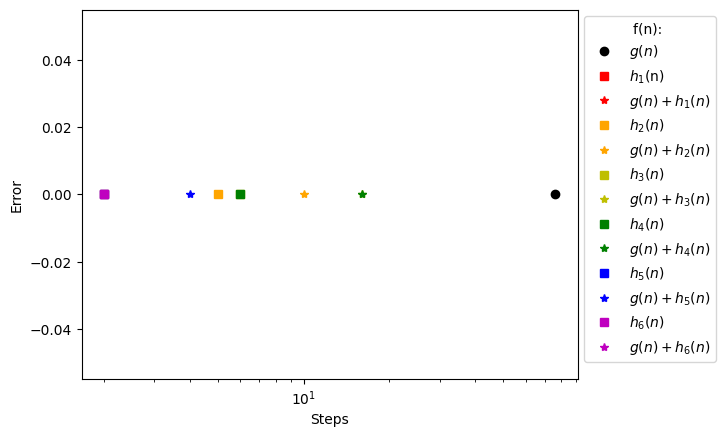

In [24]:
plt.plot(bf_steps, 0, 'ko', label="$g(n)$")
plt.plot(gbf_steps, gbf_cost - bf_cost, 'rs', label="$h_1$(n)")
plt.plot(a1_steps, a1_cost - bf_cost, 'r*', label="$g(n) + h_1(n)$")
plt.plot(gbf2_steps, gbf2_cost - bf_cost, 's', color="orange", label="$h_2(n)$")
plt.plot(a2_steps, a2_cost - bf_cost, '*', color="orange", label="$g(n) + h_2(n)$")
plt.plot(gbf3_steps, gbf3_cost - bf_cost, 'ys', label="$h_3(n)$")
plt.plot(a3_steps, a3_cost - bf_cost, 'y*', label="$g(n) + h_3(n)$")
plt.plot(gbf4_steps, gbf4_cost - bf_cost, 'gs', label="$h_4(n)$")
plt.plot(a4_steps, a4_cost - bf_cost, 'g*', label="$g(n) + h_4(n)$")
plt.plot(gbf5_steps, gbf5_cost - bf_cost, 'bs', label="$h_5(n)$")
plt.plot(a5_steps, a5_cost - bf_cost, 'b*', label="$g(n) + h_5(n)$")
plt.plot(gbf6_steps, gbf6_cost - bf_cost, 'ms', label="$h_6(n)$")
plt.plot(a6_steps, a6_cost - bf_cost, 'm*', label="$g(n) + h_6(n)$")

plt.xlabel("Steps")
plt.ylabel("Error")
plt.legend(title="f(n): ", bbox_to_anchor=(1,1), loc="upper left")
ax = plt.gca()
ax.set_xscale('log')
plt.show();

### Observations
- Some heuristics may be suited for GBF but not for A*, and viceversa
- Stricter heuristics are in general less time expensive (in terms of steps), however the function used to calculate those heuristics may be more expensive themselves 

In [34]:
def draw_points(P, bfs_steps,  results):
    plt.title("Path searching algorithm performance with $p$ = {}".format(P))
    plt.plot(np.average(bfs_steps), 0, 'ko', label="$g(n)$")
    plt.plot(np.average(results[0]), np.average(results[1]), 'rs', label="$h_1(n)$")
    plt.plot(np.average(results[2]), np.average(results[3]), 'r*', label="$g(n) + h_1(n)$")
    plt.plot(np.average(results[4]), np.average(results[5]), 's', color="orange", label="$h_2(n)$")
    plt.plot(np.average(results[6]), np.average(results[7]), '*', color="orange", label="$g(n) + h_2(n)$")
    plt.plot(np.average(results[8]), np.average(results[9]), 'ys', label="$h_3(n)$")
    plt.plot(np.average(results[10]), np.average(results[11]), 'y*', label="$g(n) + h_3(n)$")
    plt.plot(np.average(results[12]), np.average(results[13]), 'gs', label="$h_4(n)$")
    plt.plot(np.average(results[14]), np.average(results[15]), 'g*', label="$g(n) + h_4(n)$")
    plt.plot(np.average(results[16]), np.average(results[17]), 'bs', label="$h_5(n)$")
    plt.plot(np.average(results[18]), np.average(results[19]), 'b*', label="$g(n) + h_5(n)$")
    plt.plot(np.average(results[20]), np.average(results[21]), 'ms', label="$h_6(n)$")
    plt.plot(np.average(results[22]), np.average(results[23]), 'm*', label="$g(n) + h_6(n)$")
    plt.xlabel("Steps")
    plt.ylabel("Error")
    plt.legend(title="f(n): ", bbox_to_anchor=(1,1), loc="upper left")
    ax = plt.gca()
    ax.set_xscale('log')
    plt.show()

In [26]:
NUM_SETS = 64
PROBLEM_SIZE = 25
fs = {
    "$h_1(n)$": heur1,
    "$g(n) + h_1(n)$": lambda s: w * len(s.taken) + heur1(s),
    "$h_2(n)$": heur2,
    "$g(n) + h_2(n)$": lambda s: w * len(s.taken) + heur2(s),
    "$h_3(n)$": heur3,
    "$g(n) + h_3(n)$": lambda s: w * len(s.taken) + heur3(s),
    "$h_4(n)$": heur4,
    "$g(n) + h_4(n)$": lambda s: w * len(s.taken) + heur4(s),
    "$h_5(n)$": heur5,
    "$g(n) + h_5(n)$": lambda s: w * len(s.taken) + heur5(s),
    "$h_6(n)$": heur6,
    "$g(n) + h_6(n)$": lambda s: w * len(s.taken) + heur6(s),
}
results = {}
steps = {}
for P in (0.5, 0.75):
    results[P] =[[] for _ in range(len(fs.keys()) * 2)]
    steps[P] = []
    w = PROBLEM_SIZE/2 * P
    for _ in tqdm(range(100), position=0, leave=True):
        SETS = tuple(np.array([random() < P for _ in range(PROBLEM_SIZE)]) for _ in range(NUM_SETS))
        assert goal_check(State(set(range(NUM_SETS)), set())), "Problem not solvable"
        bfs_cost, bfs_steps = find_solution(verbose=False)
        steps[P].append(bfs_steps)
        for i, f in tqdm(enumerate(fs.keys()), position=1, leave=False):
            res_c, res_s = find_solution(fs[f], verbose=False)
            if res_c > -1:
                results[P][2*i].append(res_s)
                results[P][2*i+1].append(res_c - bfs_cost)

100%|██████████| 100/100 [06:47<00:00,  4.08s/it]


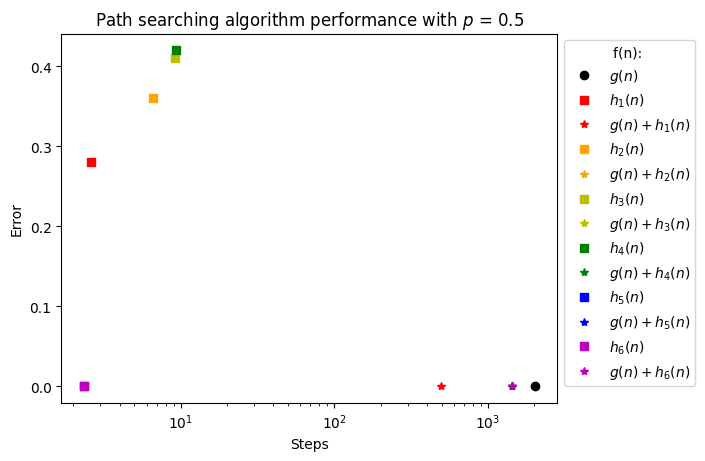

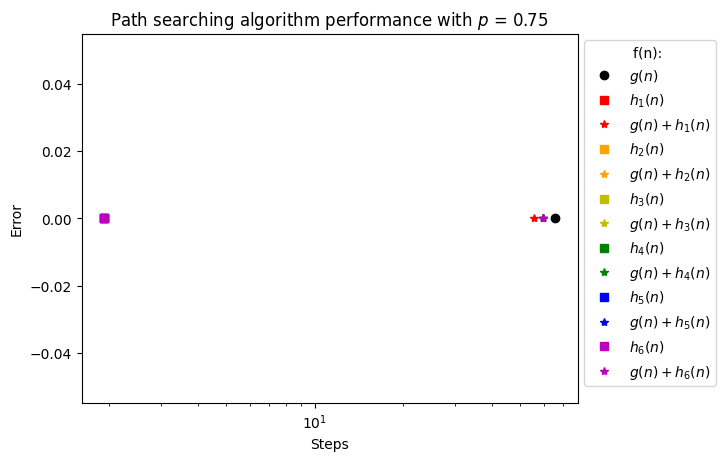

In [35]:
for p in results.keys():
    draw_points(p, steps[p], results[p])